#  PROJECT: Aave V2 Wallet Credit Score

Creating a credit scoring model for DeFi wallets based on Aave V2 transaction behavior. Output will be stored in wallet_scores.json and analyzed in graphs.

# STEP 1: IMPORT LIBRARIES

In [4]:
import json
from collections import defaultdict
from datetime import datetime, timezone
import matplotlib.pyplot as plt

# STEP 2: LOAD TRANSACTION DATA

In [6]:
# Path to the raw JSON file (downloaded from the challenge link)
INPUT_FILE = "user-wallet-transactions.json"

# Load the JSON data
with open(INPUT_FILE, "r") as f:
    data = json.load(f)

print("✅ Loaded transactions:", len(data))
print("📄 Sample record:", data[0])

✅ Loaded transactions: 100000
📄 Sample record: {'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}


# STEP 3: FEATURE ENGINEERING

In [8]:
wallet_features = defaultdict(lambda: {
    "deposit_count": 0,
    "borrow_count": 0,
    "repay_count": 0,
    "redeem_count": 0,
    "liquidation_count": 0,
    "total_deposit": 0.0,
    "total_borrow": 0.0,
    "total_repay": 0.0,
    "active_days": set()
})

for tx in data:
    wallet = tx.get("userWallet")
    action = tx.get("action", "").lower()
    amount = float(tx.get("actionData", {}).get("amount", 0)) / 1e18
    timestamp = tx.get("timestamp", 0)
    date = datetime.fromtimestamp(timestamp, tz=timezone.utc).date()

    wallet_features[wallet]["active_days"].add(date)

    if action == "deposit":
        wallet_features[wallet]["deposit_count"] += 1
        wallet_features[wallet]["total_deposit"] += amount
    elif action == "borrow":
        wallet_features[wallet]["borrow_count"] += 1
        wallet_features[wallet]["total_borrow"] += amount
    elif action == "repay":
        wallet_features[wallet]["repay_count"] += 1
        wallet_features[wallet]["total_repay"] += amount
    elif action == "redeemunderlying":
        wallet_features[wallet]["redeem_count"] += 1
    elif action == "liquidationcall":
        wallet_features[wallet]["liquidation_count"] += 1

print("✅ Feature extraction complete. Total wallets:", len(wallet_features))


✅ Feature extraction complete. Total wallets: 3497


#  STEP 4: SCORING FUNCTION

Score each wallet between 0 and 1000.

In [11]:
def score_wallet(feat):
    score = 600  # Base score

    score += feat["deposit_count"] * 5
    score += feat["repay_count"] * 10
    score -= feat["borrow_count"] * 3
    score -= feat["liquidation_count"] * 20
    score += len(feat["active_days"]) * 2

    if feat["total_borrow"] > feat["total_repay"]:
        score -= int((feat["total_borrow"] - feat["total_repay"]) * 2)

    return max(0, min(1000, score))


#  STEP 5: CALCULATE SCORES

In [13]:
wallet_scores = []

for wallet, feat in wallet_features.items():
    feat["active_days"] = list(feat["active_days"])  # convert set to list
    score = score_wallet(feat)
    wallet_scores.append({"wallet": wallet, "score": score})

print("✅ Wallets scored:", len(wallet_scores))
print("📊 Sample score:", wallet_scores[:3])


✅ Wallets scored: 3497
📊 Sample score: [{'wallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'score': 607}, {'wallet': '0x000000000051d07a4fb3bd10121a343d85818da6', 'score': 607}, {'wallet': '0x000000000096026fb41fc39f9875d164bd82e2dc', 'score': 614}]


# STEP 6: SAVE SCORES TO JSON FILE

In [15]:
with open("wallet_scores.json", "w") as f:
    json.dump(wallet_scores, f, indent=2)

print("✅ Scores saved to wallet_scores.json")

✅ Scores saved to wallet_scores.json


# STEP 7: VISUALIZE SCORE DISTRIBUTION

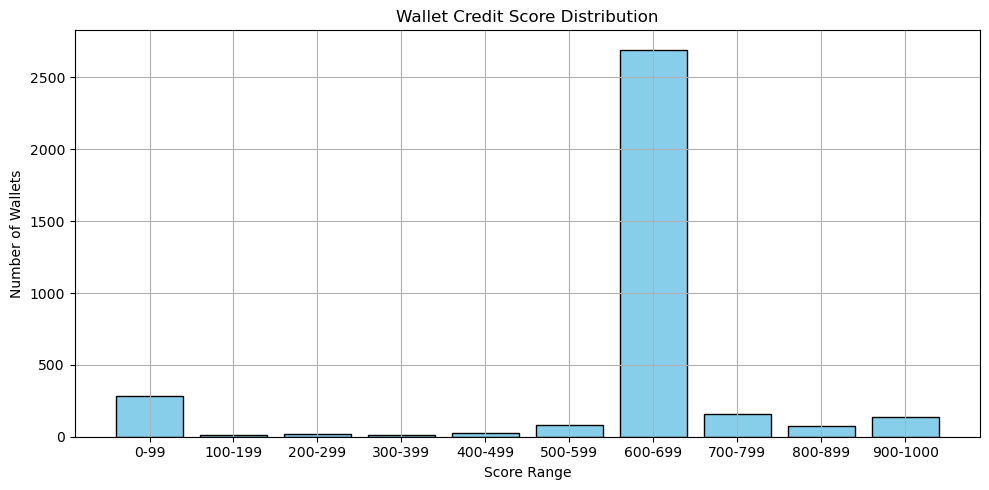

In [17]:
score_values = [entry['score'] for entry in wallet_scores]

# Group into buckets of 100 (0–99, 100–199, ..., 900–1000)
ranges = ["0-99", "100-199", "200-299", "300-399", "400-499",
          "500-599", "600-699", "700-799", "800-899", "900-1000"]
bins = [0] * 10

for s in score_values:
    index = min(s // 100, 9)
    bins[index] += 1

plt.figure(figsize=(10, 5))
plt.bar(ranges, bins, color='skyblue', edgecolor='black')
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()

In [18]:
plt.savefig("score_distribution.png")  # This line saves the graph

<Figure size 640x480 with 0 Axes>